In [1]:
import json
import re
import logging
import networkx as nx
import numpy as np
import timeit

from hashlib import md5
from rdkit import Chem, RDLogger
from rdkit.Chem import SaltRemover
from rdkit.Chem.rdChemReactions import ReactionFromSmarts
from func_timeout import func_timeout, FunctionTimedOut
from networkx.algorithms.clique import enumerate_all_cliques, find_cliques, find_cliques_recursive, max_weight_clique
from multiprocessing import Pool

# disable C++ logger for production
RDLogger.DisableLog('rdApp.*')

class CorrespondenceGraph(nx.Graph):
    '''
    Build the correspondence matrix of putative atom pairings, from which to determine the maximal clique (comprising the MCS). 
    '''
    
    def __init__(self):

        # inherit from nx.Graph
        super().__init__(self)

    def build(
        self, 
        mol1, 
        mol2, 
        strictness, 
        correspondence,
        sfunc=np.full(8, 10)):
        '''
        Build the correspondence graph.
        
        Each atomic pairing is assigned a providional score, from 0 (most different) to 8000 (identical). 
        This pairwise score is appended to the tuple representing each node, following the atomic indices.
        '''
        # ensure scoring function suitable
        assert len(sfunc) == 8
        assert (sfunc > 1).all()
        
        # store strictness for scoring
        self._mol1 = mol1
        self._mol2 = mol2
        self._strict = (sfunc.mean() * strictness) ** 2 # np.sort(sfunc)[:5].sum() ** 2
        self._corr = correspondence
        
        # calculate distance matrices
        self._dmat1 = Chem.GetDistanceMatrix(mol1)
        self._dmat2 = Chem.GetDistanceMatrix(mol2)
        
        # extract propery in such a way error is not thrown on comparison
        def getCIPCode(atom):
            try: return atom.GetProp('_CIPCode')
            except KeyError: return None
            
        # create description of how central in molecule atom
        def getPeripherality(atom, dmat):
            peripherality = dmat[atom.GetIdx()]
            return np.mean(peripherality / np.max(peripherality))            
                        
        # create lookup for atomic index mappings
        self._idxmaps = []

        # iterate over all potential atom-atom pairings
        for atom1 in self._mol1.GetAtoms():
            for atom2 in self._mol2.GetAtoms():

                # score putative nodes based on atom:atom similarity (0-88 + up to 10 point centrality bonus)
                score = np.zeros(8)
                if atom1.GetAtomicNum() == atom2.GetAtomicNum(): score[0] = 1
                if atom1.GetImplicitValence() == atom2.GetImplicitValence(): score[1] = 1
                if atom1.GetExplicitValence() == atom2.GetExplicitValence(): score[2] = 1
                if atom1.GetFormalCharge() == atom2.GetFormalCharge(): score[3] = 1
                if atom1.GetIsAromatic() == atom2.GetIsAromatic(): score[4] = 1
                if atom1.GetDegree() == atom2.GetDegree(): score[5] = 1
                if atom1.IsInRing() == atom2.IsInRing(): score[6] = 1
                if getCIPCode(atom1) == getCIPCode(atom2): score[7] = 1
                score = (score * sfunc).sum()

                # apply jitter in the event of a tie
                peripherality1 = getPeripherality(atom1, self._dmat1)
                peripherality2 = getPeripherality(atom2, self._dmat2)
                score += sfunc.min() * (1 - abs(peripherality1 - peripherality2)) * 0.999
                score = int(np.floor(score**2))
                
                # accept node with greater than specified match level
                if score >= self._strict: 
                    newmap = (atom1.GetIdx(), atom2.GetIdx())
                    self._idxmaps.append(newmap)
                    self.add_node(self._idxmaps.index(newmap), weight=score)
                    
        # build numpy matrices for weights
        self._nodeweights = np.array([self.nodes[x]['weight'] for x in self.nodes()], dtype='int64') / (sfunc.sum() ** 2)
        #self._edgeweights = np.zeros((len(self.nodes), len(self.nodes)), dtype='int64')
        
        # create correspondence graph edges
        for node1 in self.nodes():
            map1 = self._idxmaps[node1]
            for node2 in self.nodes():
                map2 = self._idxmaps[node2]
                
                # only build 1/2 matrix
                if node1 > node2: continue
                                
                # ensure any given atom is not mapped twice in a clique
                if map1[0] == map2[0] or map1[1] == map2[1]: continue

                # test if criteria are met for correspondence
                #correspondence = abs(self._dmat1[map1[0]][map2[0]] - self._dmat2[map1[1]][map2[1]])
                #score = int(np.floor(1000/((1+correspondence)**2)))

                # check comparative distance between mapped atoms is within tolerance
                if (2/3) <= self._dmat1[map1[0]][map2[0]] / self._dmat2[map1[1]][map2[1]] <= (3/2):
                    self.add_edge(node1, node2, weight=0)
                    #self._edgeweights[node1][node2] = 0
                    
        # get weighted degrees
        self._embedding = [self._nodeweights[node] * val for (node, val) in self.degree()]
        boundaries = np.sort(np.concatenate((np.logspace(3, 7, 15, base=np.e).astype(int), [np.inf, np.NINF]), axis=0))
        self._embedding = np.histogram(self._embedding, bins=boundaries)[0].tolist()
        
        # predict solution time using simple linear model
        self._predsolversecs = np.sum(self._embedding * np.array([
            0.00136326, 0.00136326, 0.00188707, 0.00241089, 0.0029347 ,
            0.00345852, 0.00398233, 0.00450614, 0.01288632, 0.01488049,
            0.02397065, 0.02899514, 0.07183043, 0.41705952, 0.7622886 ,
            0.7622886 ]))
           
    def score_clique(self, clique):
            
        # lookup scores from matrices
        score = np.sum(self._nodeweights[clique])
        #score += np.sum(self._edgeweights[clique].T[clique])   
        return score

    def filter_mcs(self, clique):
        
        # remove any atom pairings with less than perfect score, excluding bonus i.e. (11*8)**2 = 7744
        mcs = [x for x in clique if self._nodeweights[x] >= 1] 
        
        # replace integer node numbers with atomic index tuples
        mcs = [self._idxmaps[x] for x in mcs]
        clique = [self._idxmaps[x] for x in clique]
        if not len(mcs): return clique, mcs
        
        # split the tuples and homogenise the distance matrices
        idx1, idx2 = zip(*mcs)
        dmat1 = self._dmat1[list(idx1)].T[list(idx1)]
        dmat2 = self._dmat2[list(idx2)].T[list(idx2)]       
        
        # take the difference in the reduced distance matries
        dmatdiff = np.clip(dmat1, 0, self._corr) - np.clip(dmat2, 0, self._corr)
        idx1 = set([idx1[x] for x in np.where(dmatdiff != 0)[0]])
        idx2 = set([idx2[x] for x in np.where(dmatdiff != 0)[1]])

        # retain those nodes where the constituent atoms have not drifted (or explicit i.e. chiral H)
        mcs = [x for x in mcs
               if (x[0] not in idx1 or self._mol1.GetAtomWithIdx(x[0]).GetAtomicNum() == 1)
               and (x[1] not in idx2 or self._mol2.GetAtomWithIdx(x[1]).GetAtomicNum() == 1)]
        
        # return
        return clique, mcs
    
    def solve(self, solver, timeout=60):
        '''
        Enumerate cliques and rescore:
            solver=find_cliques - analyse maximal cliques only (default)
            solver=find_cliques_recursive - (recursively) analyse maximal cliques only
            solver=enumerate_all_cliques - analyse all cliques (not recommended for performance reasons)
        
        Returns:
            bestclique - the best scoring clique (including partially matching atoms, and used to derive reaction mappings)
            bestmcs - the subset of bestclique containing exact chemical matches only (to be discarded to produce the RECS)
        '''
                    
        # define function with no arguments (for use with timeout function)
        def findCliquesNoArgs(): return list(solver(self))
        
        # try finding cliques within [timeout] seconds
        try:
            cliques = func_timeout(timeout, findCliquesNoArgs)
        except FunctionTimedOut:
            logging.warning(json.dumps({"message": "failed to find cliques in {} seconds".format(timeout)}))
            return list(), list()
        
        # set up process pool and score cliques
        if len(cliques) > 1e5:
            with Pool() as p: scores = p.map(self.score_clique, cliques)
        elif len(cliques) > 0:
            scores = [self.score_clique(x) for x in cliques]
        else:
            logging.warning(json.dumps({"message": "no cliques found".format(timeout)}))
            return list(), list()
        scores = np.array(scores)
        bestscore = scores.max()
        bestclique = cliques[np.where(scores==bestscore)[0][0]]
        
        # remap to indices and remove atomic/drift based discrepancies from mcs
        bestclique, bestmcs = self.filter_mcs(bestclique)

        # return results
        return bestclique, bestmcs
                            
    def solve_weighted(self, timeout=60):
        '''
        For testing only, please do not use.
        
        Execute the maximum weight clique search.
        
        Returns:
            clique - the best scoring clique (including partially matching atoms, and used to derive reaction mappings)
            mcs - the subset of bestclique containing exact chemical matches only (to be discarded to produce the RECS)
        '''
                    
        # define function with no arguments (for use with timeout function)
        def findCliquesNoArgs(): return max_weight_clique(self)
        
        # try finding cliques within [timeout] seconds
        try:
            clique, maxweight = func_timeout(timeout, findCliquesNoArgs)
        except FunctionTimedOut:
            logging.warning(json.dumps({"message": "failed to find cliques in {} seconds".format(timeout)}))
            return list(), list()

        # lookup scores from matrices (purely for comparison with return from max_weight_cliques)
        score = self.score_clique(clique)

        # remap to indices and remove atomic/drift based discrepancies from mcs
        clique, mcs = self.filter_mcs(clique)
        
        # return results
        return clique, mcs

class Reactor():
    
    def __init__(self, smirks):        
        '''
        Instantiate MMP 'Reactor'.
        
        smirks: SMIRKS encoded reaction.
        '''
        
        self._rxn = Chem.rdChemReactions.ReactionFromSmarts(smirks)

    def assert_one2one(self):
        '''
        Assert 1:1 relationship between reactants and products.
        '''
            
        try: 
            assert self._rxn.GetNumReactantTemplates() == 1
            assert self._rxn.GetNumProductTemplates() == 1
            return True
        except AssertionError:
            logging.info(json.dumps({"message": "no 1:1 reaction could be generated"}))
            return False
     
    def generate_products(self, smiles):
        '''
        Return products as list of SMILES.
        
        smiles: SMILES to serve as seed or reactant.
        '''
            
        reactant = Chem.AddHs(Chem.MolFromSmiles(smiles))
        products = self._rxn.RunReactants((reactant,))
        productset = set()
        for product in products:
            try:
                productparts = [Chem.MolToSmiles(Chem.RemoveHs(productpart)) for productpart in product]
                productset.add('.'.join(productparts))
            except (Chem.AtomValenceException, Chem.AtomKekulizeException, Chem.KekulizeException):
                logging.info(json.dumps({"message": "MolSanitizeException raised on product enumeration"}))
        return list(productset)
    
class MMP():

    @staticmethod
    def __molFromSmiles(smiles: str):
        
        # parse smiles
        try: mol = Chem.MolFromSmiles(smiles)
        except: return None
    
        # remove salts
        remover = SaltRemover.SaltRemover()
        mol, salts = remover.StripMolWithDeleted(mol)
            
        # add hydrogen where defining isomer
        isomerics = []
        for atom in mol.GetAtoms():
            if not atom.HasProp('_CIPCode'): continue
            isomerics.append(atom.GetIdx())
        mol = Chem.AddHs(mol, onlyOnAtoms=isomerics, explicitOnly=True)
                      
        # clear mappings and initialise radii (assume all atoms are RECS)
        for atom in mol.GetAtoms(): 
            atom.SetIntProp('molAtomRadius',0)
            atom.ClearProp('molAtomMapNumber')
            
        # return
        return mol
    
    def __init__(self, smiles_x: str, smiles_y: str, strictness=4, correspondence=1):
        '''
        Initialise the matched molecular pair.
        
        smiles_x: First molecule to compare.
        smiles_y: Second molecule to compare.
        strictness: Integer (1-8) to indicate how tolerant the algortithm should to be to atom-wise chemical differences. 
            1 (slowest) all atom types match.
            8 (fastest) atoms chemically identical to be considered part of mcss.  
        correspondence: Integer (1-8) to indicate how tolerant the algortithm should to be to topological differences. 
            1 (fastest) standard MCS using exact correspondence matrix only.
            4 (slowest) atoms are allowed to 'drift' up to [correspondence] bonds away from neighbouring counterparts.  
        '''
        
        if strictness-1 not in range(8): return
        if correspondence-1 not in range(4): return
        
        # canonicalise smiles
        self._smiles1 = Chem.MolToSmiles(Chem.MolFromSmiles(smiles_x))
        self._smiles2 = Chem.MolToSmiles(Chem.MolFromSmiles(smiles_y))
         
        # initialise molecules for comparison
        self._mol1 = self.__molFromSmiles(self._smiles1)
        self._mol2 = self.__molFromSmiles(self._smiles2)
        
        # intialise correspondence graph
        self._graph = CorrespondenceGraph()
        self._graph.build(self._mol1, self._mol2, strictness, correspondence)
        
        # dummy vars
        self._clique = None
        self._mcs = None

    def __setAtomMapNumbers(self):        
        '''
        Use the indices of the best scoring clique to define the atom mappings.
        '''

        # iterate over the mappings identified from MCSS
        chargemismatch = list()
        for pair in self._clique:
            
            # increment the index to prevent atom mappings of 0
            mapIdx = self._clique.index(pair) + 1
            
            # get atoms and record list where charges mismatch (to convert to explicit +0 in smirks)
            atom1 = self._mol1.GetAtomWithIdx(pair[0])
            atom2 = self._mol2.GetAtomWithIdx(pair[1])
            if atom1.GetFormalCharge() != atom2.GetFormalCharge(): 
                chargemismatch.append(mapIdx)
            
            # map first atom
            atom1.SetIntProp('molAtomMapNumber', mapIdx)
            
            # map second atom
            atom2.SetIntProp('molAtomMapNumber', mapIdx)
            
        return chargemismatch

    def __setAtomRadii(self):
        '''
        Use the atomic radii to denote which atoms are part of the MCS. By elimination, those atoms with radii of 0 will form the RECS.
        '''

        # iterate over the remaining mappings identified from MCSS
        for pair in self._mcs:
            
            # map first atom and set radius to 99 (atom part of MCS)
            atom1 = self._mol1.GetAtomWithIdx(pair[0])
            atom1.SetIntProp('molAtomRadius',99)
            
            # map second atom and set radius to 99 (atom part of MCS)
            atom2 = self._mol2.GetAtomWithIdx(pair[1])
            atom2.SetIntProp('molAtomRadius',99)

    def execute(self, radii=4, solver=max_weight_clique):
        '''
        solver = find_cliques, find_cliques_recursive, enumerate_all_cliques, max_weight_clique
        '''
        
        # predict timeout
        if self._graph._predsolversecs > 60: 
            return [{
                'embedding': self._graph._embedding,
                'predsolversecs': self._graph._predsolversecs,
                'error': 'timeout expected - skipping'
            }]

        # find the MCS
        self._solversecs = timeit.default_timer()
        if solver == max_weight_clique: self._clique, self._mcs = self._graph.solve_weighted()
        else: self._clique, self._mcs = self._graph.solve(solver=solver)
        self._solversecs = timeit.default_timer() - self._solversecs

        # determine the % of largest molecule covered by MCS
        maxnumatoms = max(self._mol1.GetNumAtoms(), self._mol2.GetNumAtoms())
        if not maxnumatoms: 
            return [{
                'valid': False,
                'error': 'neither mol has any non-salt atoms'
            }]
        self._percentmcs = len(self._mcs) / maxnumatoms 
        if not (0 < self._percentmcs < 1): 
            return [{
                'valid': False,
                'percentmcs': self._percentmcs,
                'error': 'either none, or complete common substructure'
            }]
        
        # search, mark up atom mappings and MCS/RECS split
        chargemismatch = self.__setAtomMapNumbers()
        self.__setAtomRadii()
                
        # define function for elimination of MCS
        def eliminate(mol, radius):
            
            # preserve atoms within <radius> bonds of attachment
            toRemove = set(range(mol.GetNumAtoms()))
            for atom in mol.GetAtoms():
                if atom.GetIntProp('molAtomRadius') > 0: continue
                for x in reversed(range(radius+1)):
                    env = list(Chem.FindAtomEnvironmentOfRadiusN(mol, x, atom.GetIdx()))
                    if not len(env): continue
                    break
                for idx in env:
                    envBond = mol.GetBondWithIdx(idx)
                    toRemove.discard(envBond.GetBeginAtom().GetIdx())
                    toRemove.discard(envBond.GetEndAtom().GetIdx())
                if radius == 0:
                    toRemove.discard(atom.GetIdx())
                        
            # remove environment from core
            toRemove = list(toRemove)
            toRemove.sort(reverse=True)
            frag = Chem.EditableMol(mol)
            for atom in toRemove: frag.RemoveAtom(atom)
            frag = frag.GetMol()
            return frag
        
        def get_canonicalized_smirks(frag1, frag2, chargemismatch):
            '''
            Returns tuple of (
                smirks: str, 
                valid: bool, 
                error: str,
                biproducts: int)
            '''
            
            def getMolAtomMapNumber(atom):
                try: return atom.GetProp('molAtomMapNumber')
                except KeyError: return None
            
            # save backup in case this fails validation
            smarts1 = Chem.MolToSmarts(Chem.AddHs(frag1))
            smarts2 = Chem.MolToSmarts(Chem.AddHs(frag2))
            backup = '{}>>{}'.format(smarts1, smarts2)

            # extract index/mapping lookup of atom all (including None) mappings
            mappings1 = list(enumerate([getMolAtomMapNumber(atom) for atom in frag1.GetAtoms()]))
            mappings2 = list(enumerate([getMolAtomMapNumber(atom) for atom in frag2.GetAtoms()]))

            # strip of mappings and call MolToSmiles to define _smilesAtomOutputOrder
            for atom in frag1.GetAtoms(): atom.ClearProp('molAtomMapNumber')
            for atom in frag2.GetAtoms(): atom.ClearProp('molAtomMapNumber')
            junk1 = Chem.MolToSmiles(frag1)
            junk2 = Chem.MolToSmiles(frag2)

            # put the original mappings back
            for mapping in mappings1:
                if not mapping[1]: continue
                frag1.GetAtomWithIdx(mapping[0]).SetIntProp('molAtomMapNumber', int(mapping[1]))
            for mapping in mappings2:
                if not mapping[1]: continue
                frag2.GetAtomWithIdx(mapping[0]).SetIntProp('molAtomMapNumber', int(mapping[1]))

            # renumber according to mapping-free output order
            frag1 = Chem.RenumberAtoms(frag1, frag1.GetPropsAsDict(True,True)["_smilesAtomOutputOrder"])
            frag2 = Chem.RenumberAtoms(frag2, frag2.GetPropsAsDict(True,True)["_smilesAtomOutputOrder"])
            smarts1 = Chem.MolToSmarts(Chem.AddHs(frag1))
            smarts2 = Chem.MolToSmarts(Chem.AddHs(frag2))

            # insert explicit +0 charges where required
            for mapidx in chargemismatch: 
                smarts1 = re.sub('(?<=[0-9]):{}]'.format(mapidx), '+0:{}]'.format(mapidx), smarts1)
                smarts2 = re.sub('(?<=[0-9]):{}]'.format(mapidx), '+0:{}]'.format(mapidx), smarts2)
            
            # arbitrarily define dominant fragment and 
            hashstr1 = re.sub('(?<=:)[0-9]+(?=])', 'X', smarts1)
            hashstr2 = re.sub('(?<=:)[0-9]+(?=])', 'X', smarts2)
            if hashstr1 > hashstr2: lookup = re.findall('(?<=:)[0-9]+(?=])', smarts1)
            else: lookup = re.findall('(?<=:)[0-9]+(?=])', smarts2)   
            
            # finally replace with sequentially ordered mappings from 1
            smirks = '{}>>{}'.format(smarts1, smarts2)
            for idx, swap in enumerate(lookup):
                smirks = re.sub(':{}]'.format(swap), ':X{}]'.format(idx+1), smirks)
            smirks = re.sub(':X', ':', smirks)

            # verify 1:1 reaction
            reactor = Reactor(smirks)
            if not reactor.assert_one2one():
                return smirks, False, 'not one2one reaction', None
   
            # verify derived reaction produces original 'product'
            for test in [smirks, backup]:
                reactor = Reactor(test)
                productlist = reactor.generate_products(self._smiles1)
                if self._smiles2 in productlist:
                    return test, True, None, len(productlist) - 1
            return backup, False, 'second molecule not found amongst products enumerated from first', len(productlist)            

        # loop from 4 down to 1 bond radius to find smallest valid transformation
        responselist = list()
        for radius in reversed(range(radii+1)):
            
            # return list of valid transformations
            if radius == 0: return responselist
            
            # initialise response object
            response = {'smiles1': self._smiles1,
                        'smiles2': self._smiles2,
                        'percentmcs': self._percentmcs,
                        'radius': radius,
                        'valid': False,
                        'solversecs': self._solversecs,
                        'embedding': self._graph._embedding,
                        'predsolversecs': self._graph._predsolversecs,
                        'error': None}
            
            # Define reaction as SMIRKS while mappings still present
            frag1 = eliminate(self._mol1, radius)
            frag2 = eliminate(self._mol2, radius)   
            smirks, valid, error, biproducts = get_canonicalized_smirks(frag1, frag2, chargemismatch)

            # remove mappings to yield clean fragments
            for atom in frag1.GetAtoms(): atom.ClearProp('molAtomMapNumber')
            frag1 = Chem.MolToSmiles(frag1, allHsExplicit=True)
            for atom in frag2.GetAtoms(): atom.ClearProp('molAtomMapNumber')
            frag2 = Chem.MolToSmiles(frag2, allHsExplicit=True)
            
            # return key response elements
            response['smirks'] = smirks
            response['biproducts'] = biproducts
            response['valid'] = valid
            response['error'] = error
            response['fragment1'] = frag1
            response['fragment2'] = frag2
            responselist.append(response)

In [2]:
mmp = MMP('Cc1cccnc1', 'Cc1ccccn1', strictness=5, correspondence=2)
#mmp = MMP('Cc1oc(C)cc1', 'Cc1ccc(C)cc1', strictness=5, correspondence=2)
#mmp = MMP('c1([N+](=O)[O-])ccccc1', 'c1(C(=O)OC)ccccc1', strictness=5, correspondence=2)
#mmp = MMP('N1CCC1', 'N1CCNCC1', strictness=5, correspondence=2)

In [3]:
#mmp = MMP('Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1', 'CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C)c2)CC1', strictness=5, correspondence=2)
#mmp = MMP('CCCc1nn(C)c2c(=O)[nH]c(-c3cc(S(=O)(=O)N4CCN(C)CC4)ccc3OCC)nc12', 'CCCc1nc(C)c2c(=O)nc(-c3cc(S(=O)(=O)N4CCN(CC)CC4)ccc3OCC)[nH]n12', strictness=5, correspondence=2)

In [4]:
#mmp = MMP('CC(C)NC[C@@H](O)c1ccc(O)c(O)c1', 'CC(C)NC[C@H](O)c1ccc(O)c(O)c1', strictness=8, correspondence=1)
#mmp = MMP('CNC[C@H](O)c1cccc(O)c1', 'CNCC(=O)c1ccc(O)c(O)c1', strictness=8, correspondence=1)
#mmp = MMP('CC(C)NC[C@H](O)c1ccc(NS(C)(=O)=O)c(O)c1', 'CC(C)NC[C@H](O)c1ccc(O)c(CS(C)(=O)=O)c1', strictness=5, correspondence=1)
#mmp = MMP('CC(C)c1cc(C(O)CN)ccc1O', 'CCc1ccc(C(O)CN)cc1O', strictness=8, correspondence=1)
#mmp = MMP('CNC[C@@H](SC)c1ccc(O)c(O)c1', 'CC[C@H](NC(C)C)[C@H](O)c1ccc(O)c(O)c1', strictness=5, correspondence=1)

In [5]:
#mmp = MMP('C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CO', 'CCCC1O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]5(C)[C@H]4[C@@H](O)C[C@]3(C)[C@]2(C(=O)CO)O1', strictness=5,correspondence=1)
#mmp = MMP('C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CO', 'CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO', strictness=5,correspondence=1)
#mmp = MMP('C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)O', 'CCCC1OC2CC3C4CCC5=CC(=O)C=CC5(C)C4C(O)CC3(C)C2(C(=O)O)O1', strictness=5,correspondence=1)
#mmp = MMP('C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CO', 'CCCC1O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]5(C)[C@H]4[C@@H](O)C[C@]3(C)[C@]2(C(=O)CO)O1', strictness=5,correspondence=1)
#mmp = MMP('COc1ccc(F)cc1C(C)(C)CC(O)(Cn1cnc2ccccc21)C(F)(F)F', 'C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CO', strictness=5, correspondence=1)

In [6]:
#mmp = MMP('CC(=O)CCc1ccc2ccccc2c1', 'CC(=O)CCc1ccc2cc(Cl)ccc2c1', strictness=5, correspondence=1)
#mmp = MMP('S=c1[nH]ccn1Cc1ccccc1Cl', 'S=c1[nH]ccn1Cc1cc(Cl)ccc1Cl', strictness=5, correspondence=1)
#mmp = MMP('NC1=N[C@@H](CCc2ccccc2)CO1', 'NC1=N[C@@H](CCc2cccc(Cl)c2)CO1', strictness=5, correspondence=1)

In [7]:
(len(mmp._graph.nodes), len(mmp._graph.edges()))

(37, 256)

In [8]:
response = mmp.execute(solver=max_weight_clique)
response

[{'smiles1': 'Cc1cccnc1',
  'smiles2': 'Cc1ccccn1',
  'percentmcs': 0.7142857142857143,
  'radius': 4,
  'valid': True,
  'solversecs': 0.003090995000093244,
  'embedding': [36, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'predsolversecs': 0.05096443,
  'error': None,
  'smirks': '[#6:1](-[#6:2]1:[#6:3](:[#6:4](:[#6:5](:[#7:6]:[#6:7]:1-[H])-[H])-[H])-[H])(-[H])(-[H])-[H]>>[#6:1](-[#6:2]1:[#6:3](:[#6:4](:[#6:5](:[#6:6](:[#7:7]:1)-[H])-[H])-[H])-[H])(-[H])(-[H])-[H]',
  'biproducts': 0,
  'fragment1': '[CH3][c]1[cH][cH][cH][n][cH]1',
  'fragment2': '[CH3][c]1[cH][cH][cH][cH][n]1'},
 {'smiles1': 'Cc1cccnc1',
  'smiles2': 'Cc1ccccn1',
  'percentmcs': 0.7142857142857143,
  'radius': 3,
  'valid': True,
  'solversecs': 0.003090995000093244,
  'embedding': [36, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'predsolversecs': 0.05096443,
  'error': None,
  'smirks': '[#6:1](-[#6:2]1:[#6:3](:[#6:4](:[#6:5](:[#7:6]:[#6:7]:1-[H])-[H])-[H])-[H])(-[H])(-[H])-[H]>>[#6:1](-[#6:2]1:[#6:3](:[#6:4]

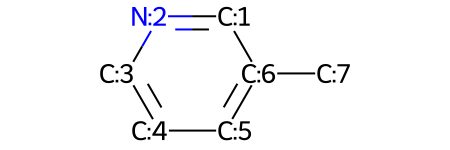

In [9]:
mmp._mol1

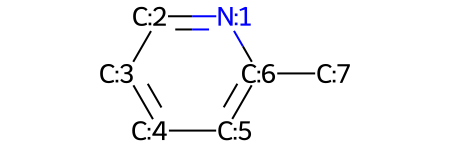

In [10]:
mmp._mol2

In [11]:
response[3]['fragment1']

'[cH2][cH][n][cH2]'

In [12]:
response[3]['smirks']

'[#6:1]:[#6:2](:[#7:3]:[#6:4]-[H])-[H]>>[#6:4](:[#6:3](:[#7:2]:[#6:1])-[H])-[H]'

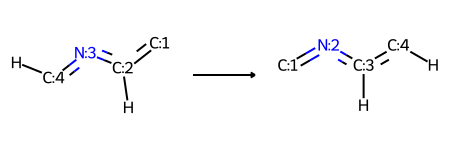

In [13]:
rxn = Chem.rdChemReactions.ReactionFromSmarts(response[3]['smirks'])
rxn

In [14]:
response[3]['fragment1']

'[cH2][cH][n][cH2]'

In [15]:
response[3]['smirks']

'[#6:1]:[#6:2](:[#7:3]:[#6:4]-[H])-[H]>>[#6:4](:[#6:3](:[#7:2]:[#6:1])-[H])-[H]'

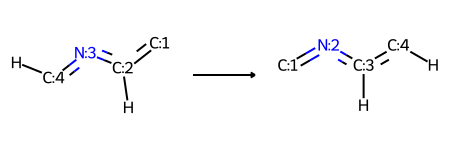

In [16]:
rxn = Chem.rdChemReactions.ReactionFromSmarts(response[3]['smirks'])
rxn

In [17]:
reactant = Chem.AddHs(Chem.MolFromSmiles(mmp._smiles1))
products = rxn.RunReactants((reactant,))

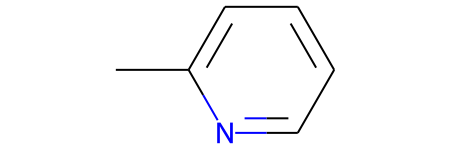

In [18]:
Chem.MolFromSmiles(Chem.MolToSmiles(products[0][0]))

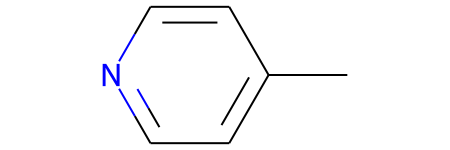

In [19]:
Chem.MolFromSmiles(Chem.MolToSmiles(products[1][0]))

In [20]:
import scipy.io as sio
m = nx.to_scipy_sparse_matrix(mmp._graph)
sio.mmwrite('test.mat', m)

/home/daniel/anaconda3/envs/wizepair-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  


AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

In [ ]:
m